# Load the data

In [1]:
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision, math, os, torch
import lightning as pl

name = 'PVAE_minimal' #change to your run name
data_dir = "./Data/Datasets/" #change to your data directory
project_name = "PVAE" #change to your wandb project name
root_dir = "data"
bsize = 256
train_device = "0"
device = train_device + "," #lightning device formatting
checkpoint_dir = os.path.join(root_dir, name)
os.makedirs(checkpoint_dir, exist_ok=True)

In [2]:
import sys
import os

# Go one level up from the notebooks directory
sys.path.append(os.path.abspath(".."))

from pvae.encoder import PL_PVAE

In [3]:
ds_train = datasets.MNIST(data_dir, train=True, download=True).data
ds_test = datasets.MNIST(data_dir, train=False, download=True).data

ds_train_targets = datasets.MNIST(data_dir, train=True, download=True).targets
ds_test_targets = datasets.MNIST(data_dir, train=False, download=True).targets

ds_train = (ds_train.float().reshape(-1, 784)/255)
ds_test = (ds_test.float().reshape(-1, 784)/255)
ds_train = torch.utils.data.TensorDataset(ds_train, ds_train_targets)
ds_test = torch.utils.data.TensorDataset(ds_test, ds_test_targets)

# Add num_workers for better performance
train_dl = DataLoader(ds_train, batch_size=bsize, shuffle=True, num_workers=4)
val_dl = DataLoader(ds_test, batch_size=bsize, shuffle=False, num_workers=4)

In [4]:
next(iter(train_dl))[0].shape

torch.Size([256, 784])

In [5]:
# from pvae.encoder import PL_PVAE

train_model = False

if train_model:
    model = PL_PVAE(train_dl)
    trainer_args = {
        "callbacks": [pl.pytorch.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_elbo', save_top_k=1, mode='min', verbose=True)],
        "accelerator": "cpu" if device == 'cpu' else "gpu",
        "gradient_clip_val": 1.0,
    }
    #trainer_args["logger"].watch(model, log="all")
    if device != 'cpu':
        trainer_args["devices"] = device
    trainer = pl.Trainer(**trainer_args, default_root_dir=checkpoint_dir, max_epochs=55, num_sanity_val_steps=0)
    trainer.fit(model, val_dataloaders=val_dl, train_dataloaders=train_dl)
else:
    f = './../data/PVAE_minimal/epoch=54-step=12925.ckpt'
    model = PL_PVAE.load_from_checkpoint(f, train_dl=train_dl)

Using device: mps
target: tensor(6)
torch.Size([76, 1, 128])
torch.Size([1, 128])
torch.Size([76, 1, 128])


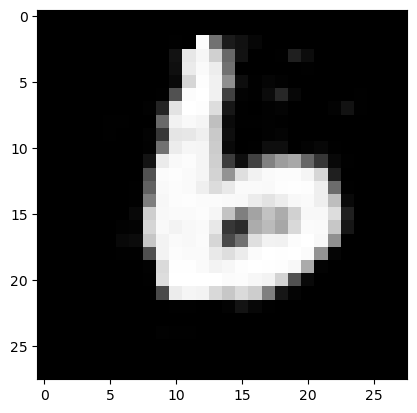

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

batch = next(iter(train_dl))
img = batch[0][0]
target = batch[1][0]

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move model and tensor to the same deviceprint(times.shape)
model = model.to(device)
x = img.to(device)

with torch.no_grad():
    dist, du, z, y = model.forward(x.unsqueeze(0).unsqueeze(0))


plt.imshow(y[0].cpu().numpy().reshape(28, 28), cmap='gray')
print('target:', target)

sample, indicator, times = dist.rsample(hard=True, return_indicator=True)

print(times.shape)
print(sample.shape)
print(indicator.shape)

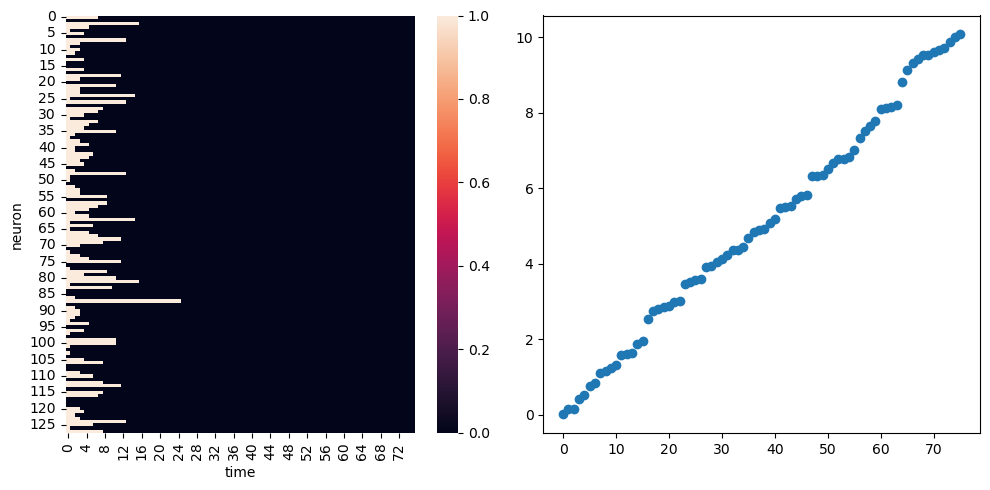

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(indicator[:,0,:].long().cpu().numpy().T, ax=ax[0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('neuron')

t = times[:,0,:][:,0].cpu().numpy()
ax[1].scatter(torch.arange(len(t)), t)

plt.tight_layout()
plt.show()

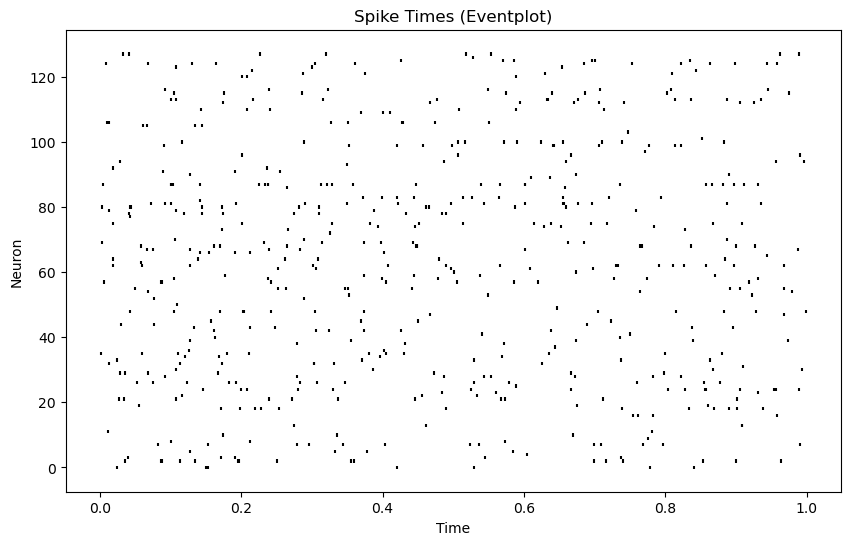

In [8]:
# Extract the spike times for each neuron
# We use the fact that indicator and times have shape (n_trials, 1, n_neurons)
indicator_np = indicator[:, 0, :].cpu().numpy()  # shape: (n_trials, n_neurons)
times_np = times[:, 0, :].cpu().numpy()          # shape: (n_trials, n_neurons)

# Create one spike train for each neuron based on the indicator mask
spike_trains = [times_np[:, i][indicator_np[:, i]] for i in range(indicator_np.shape[1])]

# Plot the spike times as an eventplot
plt.figure(figsize=(10, 6))
plt.eventplot(spike_trains, colors='black')
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Spike Times (Eventplot)")
plt.show()

In [ ]:
# ULTRA-FAST VERSION - Maximum optimization
from tqdm.notebook import tqdm
from pvae.utils import cumulative_spike_matrix
from torch.utils.data import Subset


n_timesteps = 100   # determines time consant
n_repeats = 10      # Number of repeats for sampling


def create_decoder_dataset_fast(model, dataset, n_timesteps=100, n_repeats=10, max_samples=10000):
    """
    Ultra-fast version that limits the dataset size and uses maximum vectorization.
    """
    model = model.to(device)
    model.eval()
    
    # Limit dataset size for speed
    limited_dataset = torch.utils.data.Subset(dataset, range(min(max_samples, len(dataset))))
    
    # Use DataLoader for better batching
    fast_loader = DataLoader(limited_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for batch_imgs, batch_labels in tqdm(fast_loader, desc="Ultra-fast processing"):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            
            # Process each image in the batch
            for img, label in zip(batch_imgs, batch_labels):
                # Get distribution
                dist, du, z, y = model.forward(img.unsqueeze(0).unsqueeze(0))
                
                # Sample multiple times efficiently
                for _ in range(n_repeats):
                    sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
                    cum_matrix = cumulative_spike_matrix(indicator, times, n_steps=n_timesteps)
                    
                    # Add all timesteps at once
                    all_data.append(cum_matrix.T.cpu())  # (n_timesteps, n_neurons)
                    all_labels.extend([label.cpu().item()] * n_timesteps)
    
    # Stack everything
    decoder_data = torch.cat(all_data, dim=0)
    decoder_labels = torch.tensor(all_labels, dtype=torch.long)
    
    return decoder_data, decoder_labels, dist

# Use the ultra-fast version (processes only first 1000 images for speed)
print("Creating decoder dataset with ultra-fast method...")



Creating decoder dataset with ultra-fast method...


In [10]:
load_decoder = False

if load_decoder:
    # load saved decoder data and labels
    decoder_data_fast = torch.load('./data/decoder/decoder_data_fast.pt')
    decoder_labels_fast = torch.load('./data/decoder/decoder_labels_fast.pt')
else:
    decoder_data_fast, decoder_labels_fast, dist_fast = create_decoder_dataset_fast(
        model, ds_train, n_timesteps=n_timesteps, n_repeats=n_repeats, max_samples=7
        )

    # Save decoder data and labels
    torch.save(decoder_data_fast, './data/decoder/decoder_data_fast.pt')
    torch.save(decoder_labels_fast, './data/decoder/decoder_labels_fast.pt')


print(f"Fast decoder data shape: {decoder_data_fast.shape}")
print(f"Fast decoder labels shape: {decoder_labels_fast.shape}")

Ultra-fast processing:   0%|          | 0/1 [00:00<?, ?it/s]

Fast decoder data shape: torch.Size([7000, 128])
Fast decoder labels shape: torch.Size([7000])


In [11]:
# Decoder data is the number of spikes. shape = (n timesteps, n_neurons)
print(decoder_data_fast)

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [14,  2,  7,  ...,  2, 10,  7],
        [14,  2,  7,  ...,  2, 10,  7],
        [15,  2,  7,  ...,  2, 10,  8]])


In [12]:
# decoder labels are the categories. shape = (n timesteps)
decoder_labels_fast

tensor([5, 5, 5,  ..., 1, 1, 1])

In [13]:
decoder_labels_fast.shape

torch.Size([7000])

In [14]:
decoder_data_fast.shape

torch.Size([7000, 128])

In [15]:
# Create a train_loader for the fast decoder data

from torch.utils.data import TensorDataset
dataset = TensorDataset(decoder_data_fast, decoder_labels_fast)
decoder_train_loader_fast = DataLoader(dataset, batch_size=bsize, shuffle=True)
print(f"Fast decoder train loader created with {len(decoder_train_loader_fast.dataset)} samples.")
print(f"Batch size: {bsize}, Number of batches: {len(decoder_train_loader_fast)}")

Fast decoder train loader created with 7000 samples.
Batch size: 256, Number of batches: 28


In [ ]:
from pvae.decoder import MLP

input_size = 128 # ecoder_data_fast.shape[1]  # Number of neurons
output_size = 10  # Number of classes

decoder = MLP(input_size=input_size, output_size=output_size)
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Instead of logistic regression, since logistic is for binary classification
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

# mlp.train(spike_trains, num_epochs=100, criterion=criterion, optimizer=optimizer, batch_size=32)
decoder.fit(train_loader=decoder_train_loader_fast, optimizer=optimizer, criterion=criterion, num_epochs=100)

# x = x.cpu()
# logits = decoder()
# print("Logits shape:", logits.shape)
# probs = torch.softmax(logits, dim=1)

# Evaluate the MLP
# mlp.evaluate(spike_train_loader)

Epoch [1/100], Loss: 0.6345
Epoch [2/100], Loss: 0.2707
Epoch [3/100], Loss: 0.1870
Epoch [4/100], Loss: 0.1011
Epoch [5/100], Loss: 0.0654
Epoch [6/100], Loss: 0.0156
Epoch [7/100], Loss: 0.0414
Epoch [8/100], Loss: 0.0254
Epoch [9/100], Loss: 0.0143
Epoch [10/100], Loss: 0.0119
Epoch [11/100], Loss: 0.0351
Epoch [12/100], Loss: 0.0162
Epoch [13/100], Loss: 0.0026
Epoch [14/100], Loss: 0.0149
Epoch [15/100], Loss: 0.0067
Epoch [16/100], Loss: 0.0147
Epoch [17/100], Loss: 0.0008
Epoch [18/100], Loss: 0.0009
Epoch [19/100], Loss: 0.0039
Epoch [20/100], Loss: 0.0190
Epoch [21/100], Loss: 0.0044
Epoch [22/100], Loss: 0.0024
Epoch [23/100], Loss: 0.0142
Epoch [24/100], Loss: 0.0037
Epoch [25/100], Loss: 0.0034
Epoch [26/100], Loss: 0.0002
Epoch [27/100], Loss: 0.0163
Epoch [28/100], Loss: 0.0021
Epoch [29/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0056
Epoch [31/100], Loss: 0.0054
Epoch [32/100], Loss: 0.0005
Epoch [33/100], Loss: 0.0002
Epoch [34/100], Loss: 0.0027
Epoch [35/100], Loss: 0

In [34]:
x = decoder_data_fast[0]   # one sample, shape [784]

print("Input shape:", x.shape)  # [784]

x = x.float()

logits = decoder(x)

# probabilities
probs = torch.softmax(logits, dim=0)

print("Logits shape:", logits)   # [1, 10]
print("Probabilities shape:", probs)  # [1, 10]

Input shape: torch.Size([128])
Logits shape: tensor([ 0.4702,  0.9409, -3.5570, -4.8762, -1.6698,  5.0806, -4.9675, -6.1024,
        -5.3252, -1.6823], grad_fn=<ViewBackward0>)
Probabilities shape: tensor([9.6722e-03, 1.5486e-02, 1.7240e-04, 4.6092e-05, 1.1380e-03, 9.7228e-01,
        4.2070e-05, 1.3523e-05, 2.9419e-05, 1.1239e-03],
       grad_fn=<SoftmaxBackward0>)


In [29]:
output_size

10

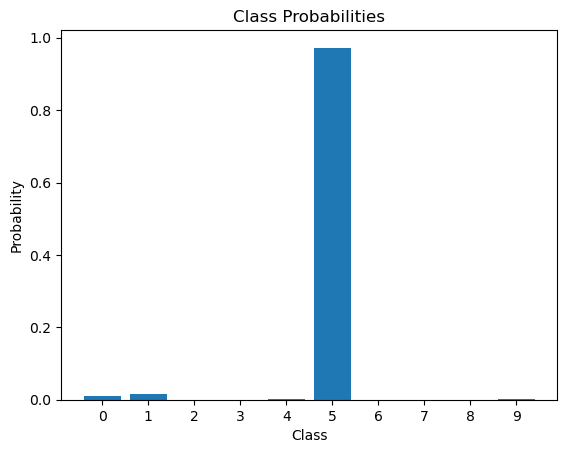

In [35]:
# plot probabilities over classes
import matplotlib.pyplot as plt
plt.bar(range(output_size), probs.detach().cpu().numpy())
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.xticks(range(output_size))
plt.show()